<a href="https://colab.research.google.com/github/jjayli/my-data-science/blob/main/notebooks/bike_sharing_demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 자전거 수요 분석 & 랜덤포레스트 예측
(Bike Sharing Demand)

Kaggle의 Bike Sharing Demand 데이터를 기반으로
시간·날씨·계절·기온과 같은 특징들이 자전거 대여 수요에 어떤 영향을 미치는지 분석해보고
머신러닝 모델을 통해 수요를 예측보겠습니다.
자세한 데이터 내용은 아래의 캐글 링크 참고

[Kaggle Bike Sharing Demand](https://www.kaggle.com/c/bike-sharing-demand/data/)

* 분석 목표
  - 시간대별, 계절별, 날씨별 자전거 대여 패턴을 탐색
  - 자전거 대여 수요에 영향을 주는 주요 요인 파악
  - 간단한 예측 모델 생성

datetime - 시간 날짜

season - **1 = 봄**, 2 = 여름, 3 = 가을, 4 = 겨울

holiday - 해당 요일이 공휴일인지 여부

workingday - 해당 요일이 주말이나 공휴일이 아닌지 여부

weather - 1: 맑음, 2: 흐림, 3: 가벼운 눈, 비, 4: 폭우, 대설

temp - 섭씨 온도

atemp - 섭씨 체감 온도

humidity - 상대 습도

windspeed - 풍속

casual - 등록된 사용자 대여가 시작된 횟수

registered - 등록된 사용자 대여가 시작된 횟수

count - 총 대여 횟수

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (9,957 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and dire

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error

In [ ]:
import matplotlib.font_manager as fm

!apt-get update -qq
!apt-get install fonts-nanum* -qq

fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'})

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum-coding.
(Reading database ... 121737 files and directories currently installed.)
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
train = pd.read_csv("train.csv", parse_dates=["datetime"])
test = pd.read_csv("test.csv", parse_dates=["datetime"])


print(train.info())
print(train.head(1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB
None
    datetime  season  holiday  workingday  weather  temp   atemp  humidity  \
0 2011-01-01       1        0           0        1  9.84  14.395

In [ ]:
print(train.shape)
# 1만행, 12컬럼
print(train.describe())

(10886, 12)
                            datetime        season       holiday  \
count                          10886  10886.000000  10886.000000   
mean   2011-12-27 05:56:22.399411968      2.506614      0.028569   
min              2011-01-01 00:00:00      1.000000      0.000000   
25%              2011-07-02 07:15:00      2.000000      0.000000   
50%              2012-01-01 20:30:00      3.000000      0.000000   
75%              2012-07-01 12:45:00      4.000000      0.000000   
max              2012-12-19 23:00:00      4.000000      1.000000   
std                              NaN      1.116174      0.166599   

         workingday       weather         temp         atemp      humidity  \
count  10886.000000  10886.000000  10886.00000  10886.000000  10886.000000   
mean       0.680875      1.418427     20.23086     23.655084     61.886460   
min        0.000000      1.000000      0.82000      0.760000      0.000000   
25%        0.000000      1.000000     13.94000     16.665000   

In [ ]:
train.isnull().sum()
# null값 없음

,0
datetime,0
season,0
holiday,0
workingday,0
weather,0
temp,0
atemp,0
humidity,0
windspeed,0
casual,0



1. 시간대별 대여량 확인

In [ ]:
# train 데이터 시간대별 대여량을 확인하기 위한 시간값 컬럼 추가
train['hour'] = train['datetime'].dt.hour
train['day']  = train['datetime'].dt.day
train['month'] = train['datetime'].dt.month
train['year']  = train['datetime'].dt.year
train['dayofweek']  = train['datetime'].dt.dayofweek

In [ ]:
# test 데이터 시간대별 대여량을 확인하기 위한 시간값 컬럼 추가
test['hour'] = test['datetime'].dt.hour
test['day']  = test['datetime'].dt.day
test['month'] = test['datetime'].dt.month
test['year']  = test['datetime'].dt.year
test['dayofweek']  = test['datetime'].dt.dayofweek

In [ ]:
train.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month,year,dayofweek
0,2011-01-01,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1,1,2011,5


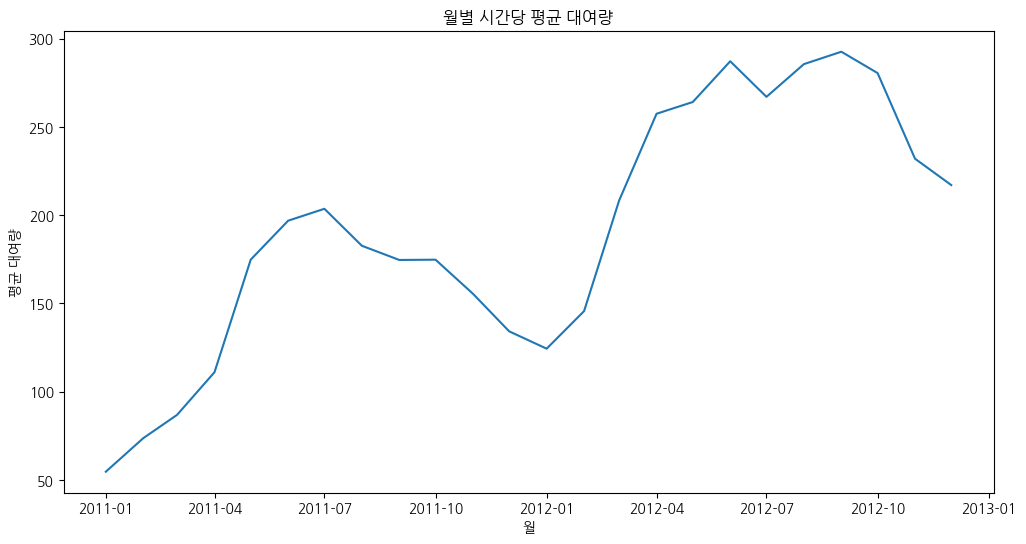

In [ ]:
monthly = train.groupby(['year', 'month'])['count'].mean().reset_index()
monthly['date'] = pd.to_datetime(monthly[['year', 'month']].assign(day=1))
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly, x='date', y='count')
plt.title("월별 시간당 평균 대여량")
plt.xlabel("월")
plt.ylabel("평균 대여량")
plt.show()

# 지속적으로 대여량이 증가하는 추세
# 2년의 시계열 그래프에서 계절적 특성 확인
# 따뜻한 계절 증가, 추운 계절 대여량 감소

전체 및 그룹별 카운트 확인

[Text(0.5, 0, 'hour'), Text(0.5, 1.0, '시간별 평균 대여량')]

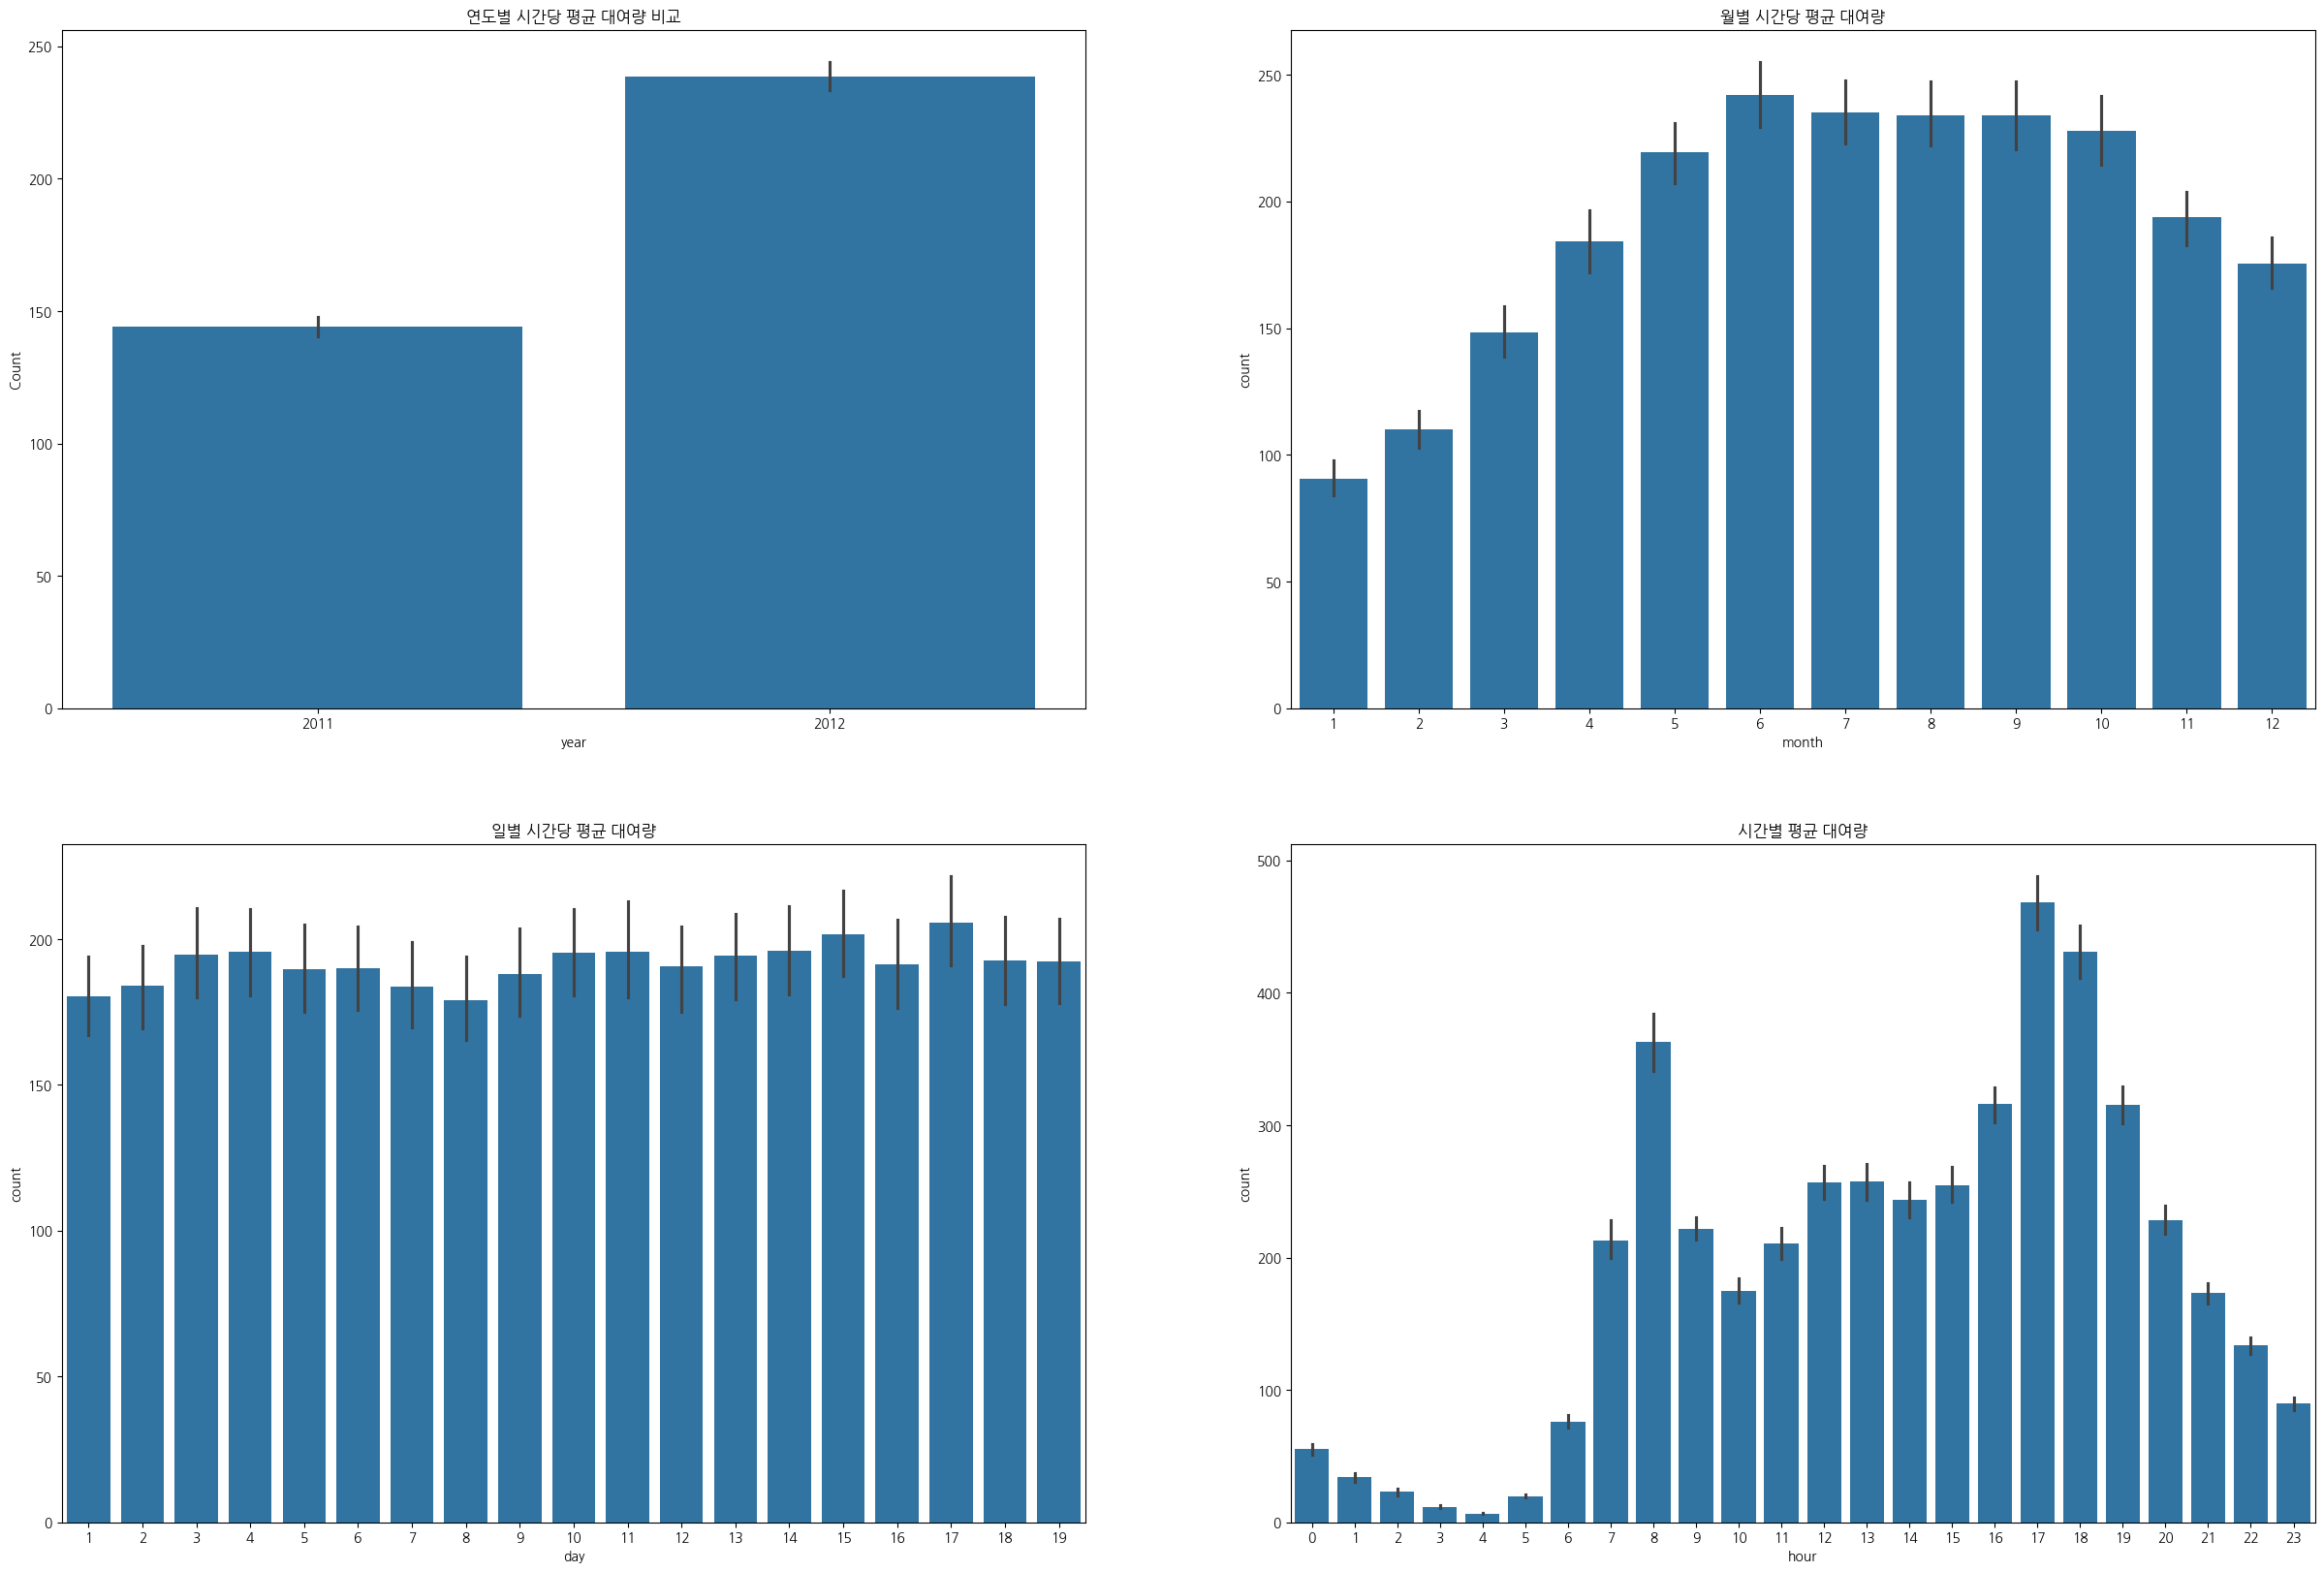

In [ ]:
figure, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(30,20)

sns.barplot(data=train, x="year", y="count", ax=ax1)
sns.barplot(data=train, x="month", y="count", ax=ax2)
sns.barplot(data=train, x="day", y="count", ax=ax3)
sns.barplot(data=train, x="hour", y="count", ax=ax4)

ax1.set(ylabel='Count',title="연도별 시간당 평균 대여량 비교")
ax2.set(xlabel='month',title="월별 시간당 평균 대여량")
ax3.set(xlabel='day', title="일별 시간당 평균 대여량")
ax4.set(xlabel='hour', title="시간별 평균 대여량")

In [ ]:
average_users_per_years = train.groupby('year')['count'].mean()
average_users_per_month = train.groupby('month')['count'].mean()
average_users_per_day = train.groupby('day')['count'].mean()
print(average_users_per_years, average_users_per_month,average_users_per_day)

year
2011    144.223349
2012    238.560944
Name: count, dtype: float64 month
1      90.366516
2     110.003330
3     148.169811
4     184.160616
5     219.459430
6     242.031798
7     235.325658
8     234.118421
9     233.805281
10    227.699232
11    193.677278
12    175.614035
Name: count, dtype: float64 day
1     180.333913
2     183.910995
3     194.696335
4     195.705575
5     189.765217
6     189.860140
7     183.773519
8     179.041812
9     187.897391
10    195.183566
11    195.679577
12    190.675393
13    194.160279
14    195.829268
15    201.527875
16    191.353659
17    205.660870
18    192.605684
19    192.311847
Name: count, dtype: float64


In [ ]:
train['day'].unique()
# 일 데이터는 19일까지 존재

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19], dtype=int32)

<Axes: xlabel='hour', ylabel='count'>

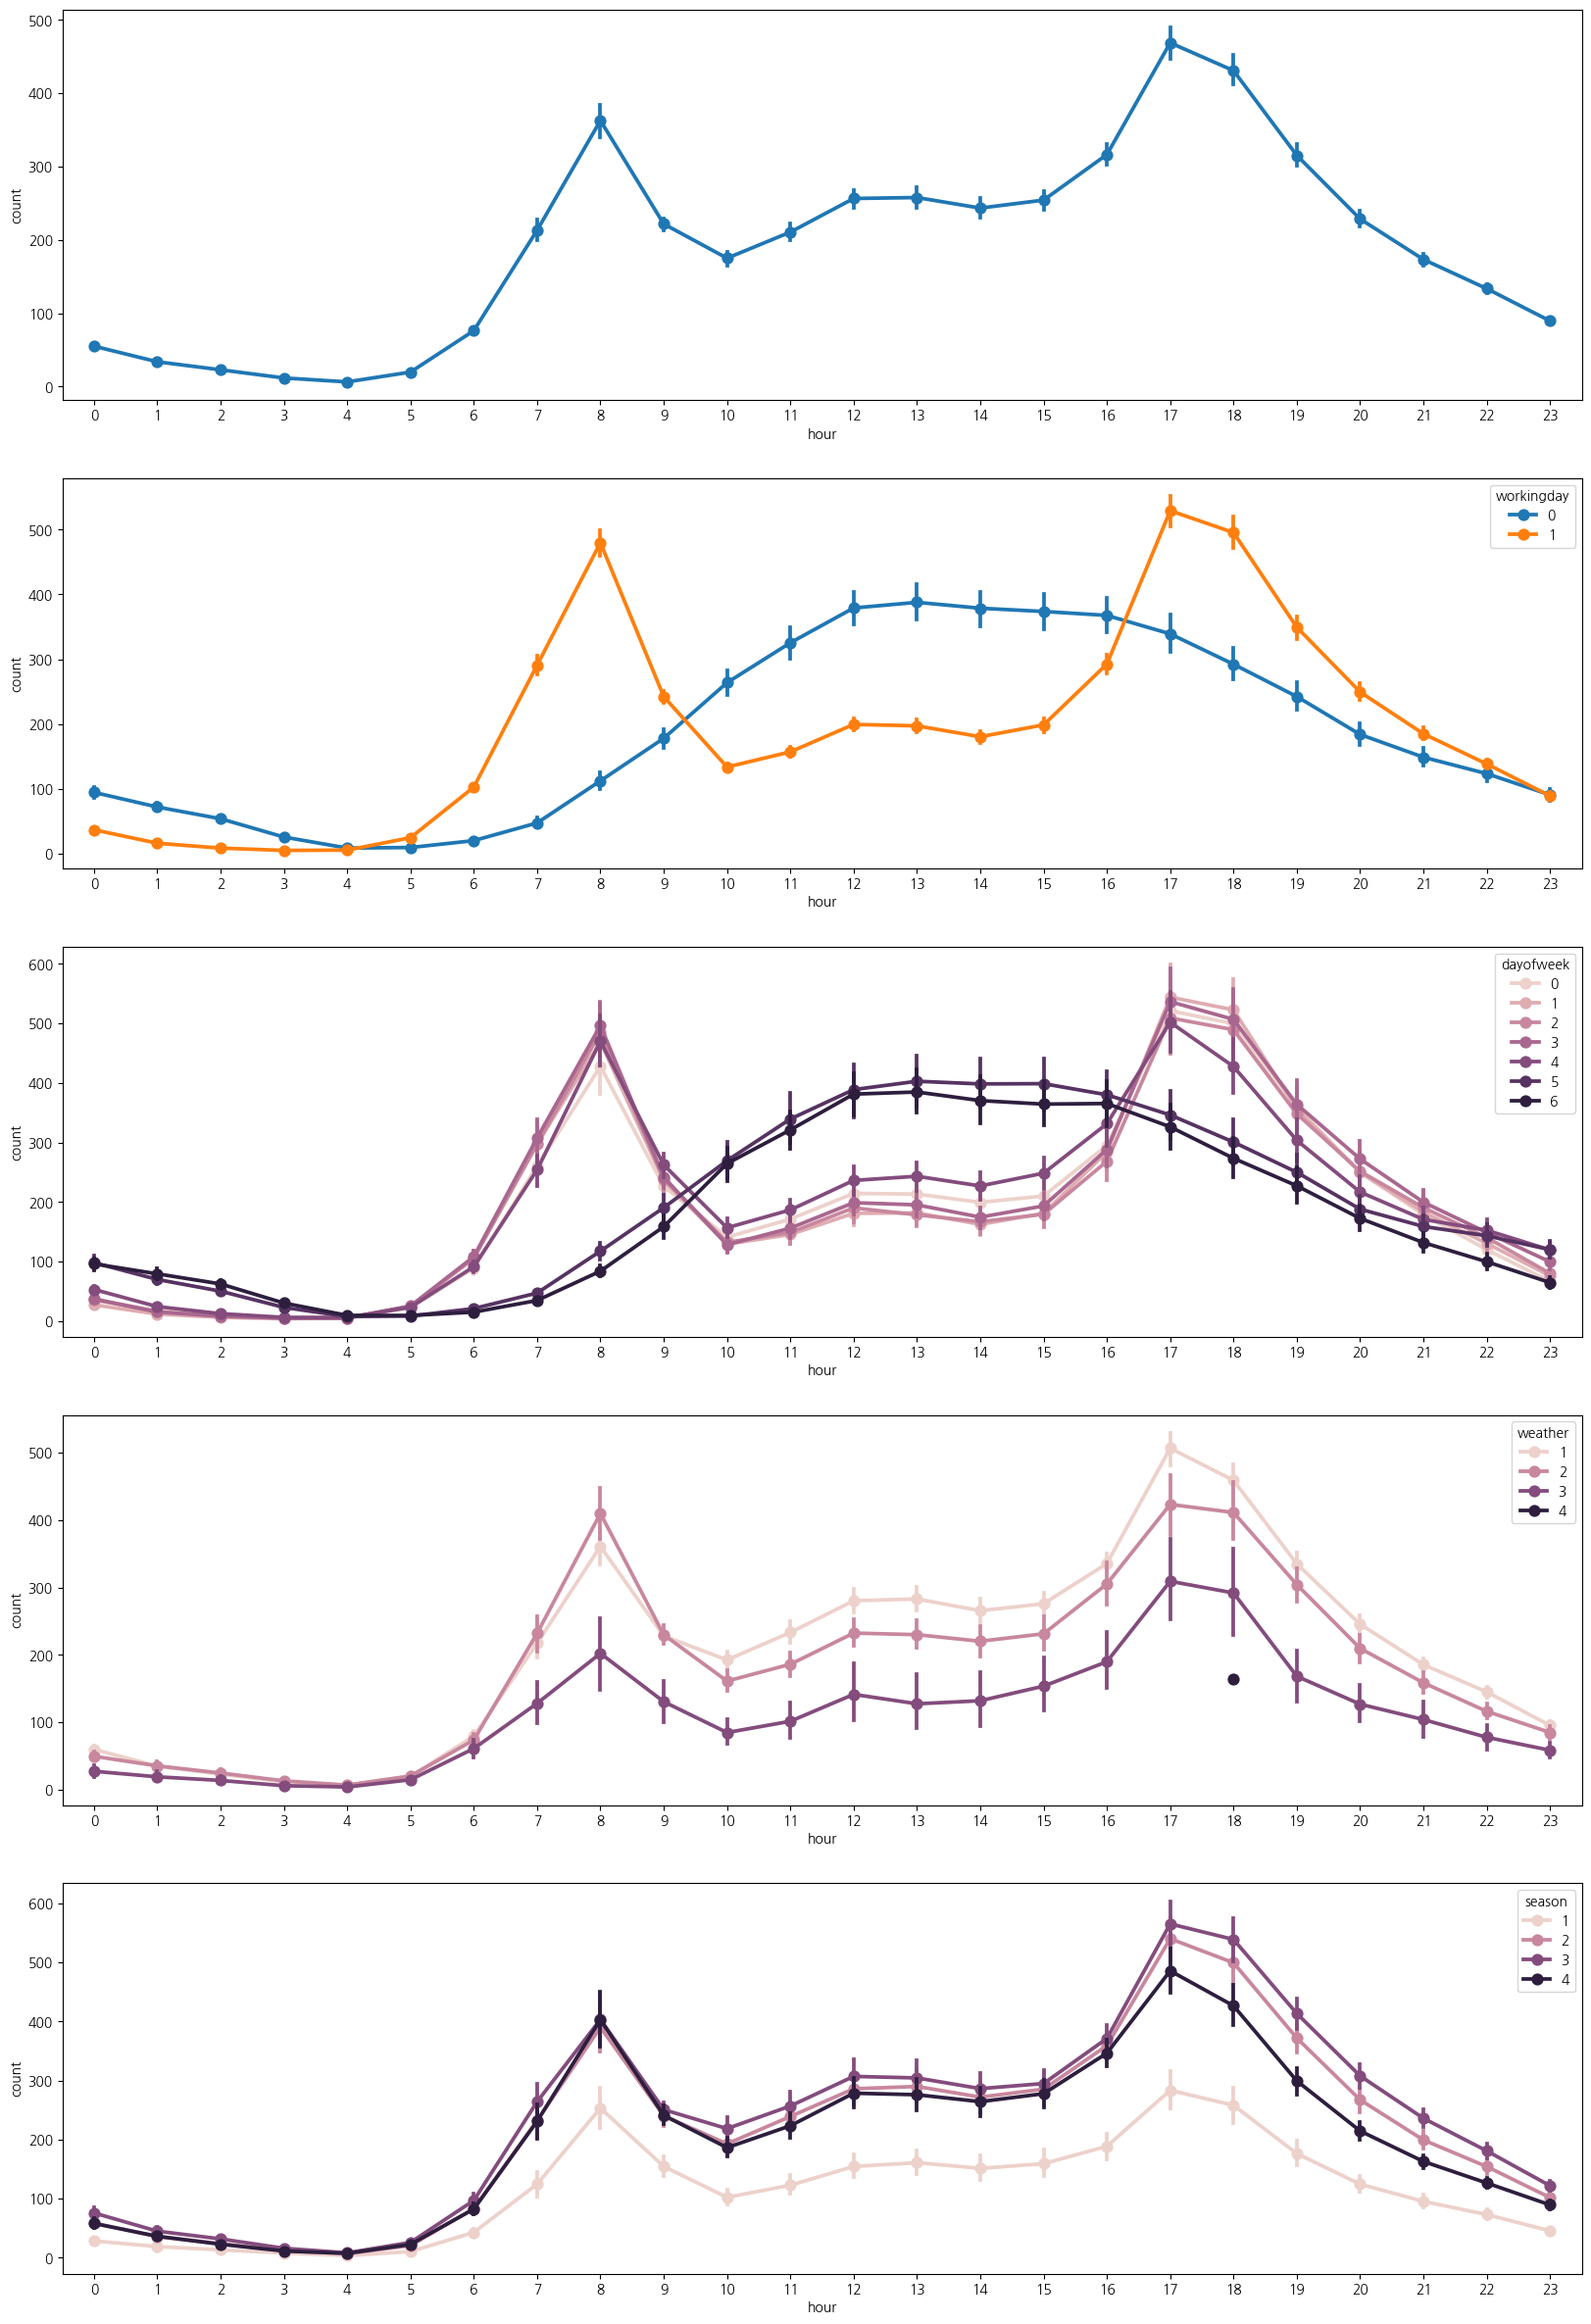

In [ ]:

fig,(ax1,ax2,ax3,ax4,ax5)= plt.subplots(nrows=5)
fig.set_size_inches(20,30)

sns.pointplot(data=train, x="hour", y="count", ax=ax1)
sns.pointplot(data=train, x="hour", y="count", hue="workingday", ax=ax2)
sns.pointplot(data=train, x="hour", y="count", hue="dayofweek", ax=ax3)
sns.pointplot(data=train, x="hour", y="count", hue="weather", ax=ax4)
sns.pointplot(data=train, x="hour", y="count", hue="season", ax=ax5)

날씨에 따른 시간별 대여량 그래프 확인 결과 날씨4 조건에서 18시 점으로 나타남.
날씨4 조건에 해당하는 날은 Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog


In [ ]:
# 1행 존재, 18시에만 날씨 호전 가능성
weather4 = train[train['weather'] == 4]
weather4

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month,year,dayofweek
5631,2012-01-09 18:00:00,1,0,1,4,8.2,11.365,86,6.0032,6,158,164,18,9,1,2012,0


* 주중 출퇴근 시간 때인 오전 6시와 오후 17, 18시에 수요가 급증 항목 추가
* 주말은 오후시간 때 수요가 고르게 분포, 주중의 수요와 다른 패턴
* 날씨가 좋을 수록 대여량 증가, 겨울 대여량 감소
* 봄이 자전거 수요가 제일 적게 나타남. season 1의 오타 가능성


,datetime
season,
1,2011-01-01
2,2011-04-01
3,2011-07-01
4,2011-10-01


,season,temp
0,1,12.530491
1,2,22.823483
2,3,28.789111
3,4,16.649239


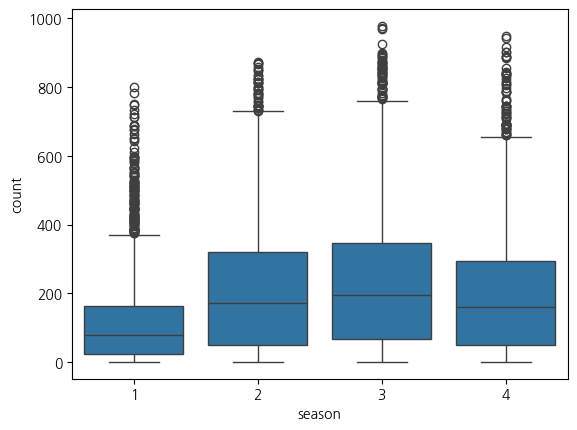

In [ ]:
# 겨울이 봄보다 대여량이 많게 확인
sns.boxplot(data=train, x='season', y='count')

# # 계절별 대여량 확인
# display(train.groupby(['season'])['count'].mean())

# 계절과 시간, 온도 비교
display(train.groupby(['season'])['datetime'].min())

average_temp_per_season = train.groupby('season', observed=False)['temp'].mean().reset_index()
display(average_temp_per_season)

# 월과 평균 온도 비교 -> 1이 겨울.
# Season 1 (1,2,3월): 겨울 (이전: 봄)
# Season 2 (4,5,6월): 봄 (이전: 여름)
# Season 3 (7,8,9월): 여름 (이전: 가을)
# Season 4 (10,11,12월): 가을 (이전: 겨울)



<Axes: xlabel='weather', ylabel='count'>

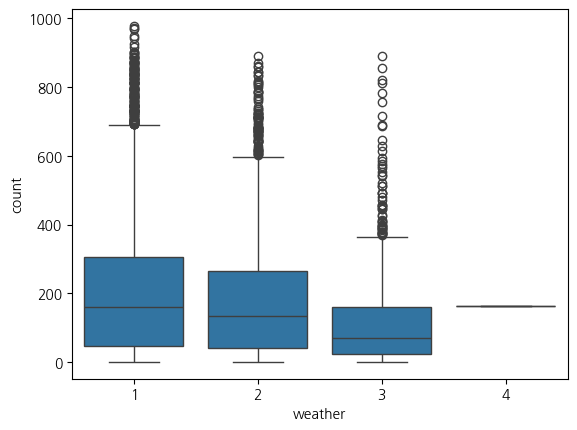

In [ ]:
# 날씨 좋음 순서대로 수요 비례 1 -> 4
sns.boxplot(data=train, x='weather', y='count')

In [ ]:
train.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month,year,dayofweek
0,2011-01-01,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1,1,2011,5


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()


<Axes: >

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


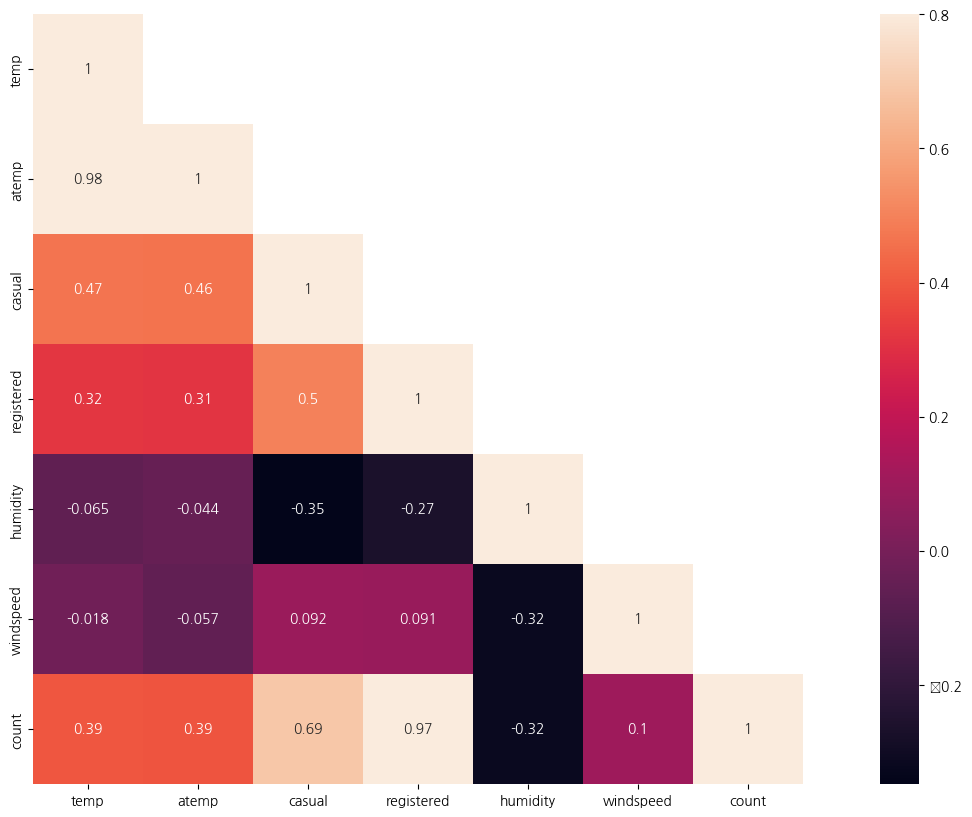

In [ ]:

# 상관관계 행렬 계산(피어슨 상관계수 사용)
# 마스크 생성=중복된 정보 제거, 행렬의 하삼각 부분만 표시하고 상삼각 부분은 가림

corr = train[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corr, mask=mask,vmax=.8, square=True,annot=True)

<Axes: xlabel='humidity', ylabel='count'>

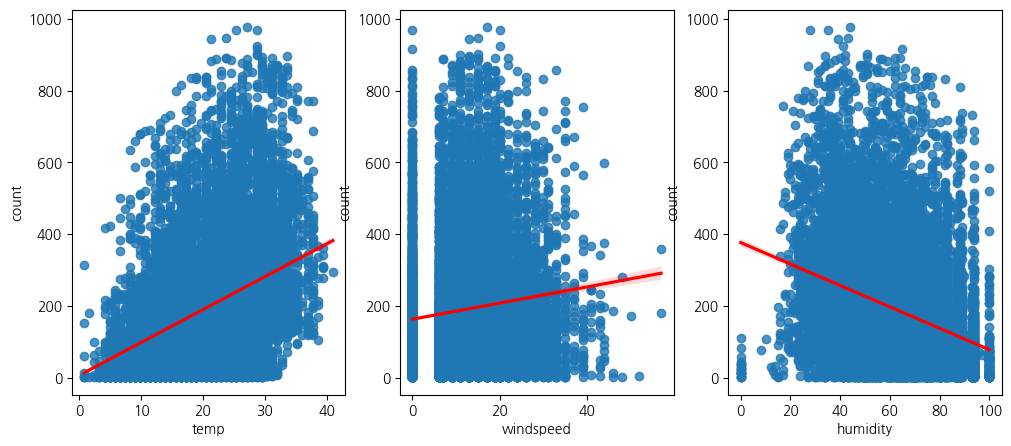

In [ ]:
# 기온, 풍속, 습도 체감온도는 생략
# 산점도와 최소제곱법으로 계산된 회귀선(레드)
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="temp", y="count", data=train,ax=ax1, line_kws={'color': 'red'})
sns.regplot(x="windspeed", y="count", data=train,ax=ax2, line_kws={'color': 'red'})
sns.regplot(x="humidity", y="count", data=train,ax=ax3, line_kws={'color': 'red'})

In [ ]:
import statsmodels.api as sm

# 풍속이 대여량을 얼마나 잘 나타낼 수 있는지 체크
X = train[['windspeed']]
X = sm.add_constant(X)  # 절편 추가
y = train['count']


# OLS 회귀 체크
model = sm.OLS(y, X).fit()

print(model.summary())

df_nonzero = train[train['windspeed'] > 0]

X2 = df_nonzero[['windspeed']]
X2 = sm.add_constant(X2)
y2 = df_nonzero['count']

model_nonzero = sm.OLS(y2, X2).fit()
print(model_nonzero.summary())

# 0인 값을 포함한 평균 풍속
mean_windspeed_all = train['windspeed'].mean()
print(f"0 포함: {mean_windspeed_all:.2f}")

# 0인 값을 제외한 평균 풍속
mean_windspeed_nonzero = df_nonzero['windspeed'].mean()
print(f"0 제외: {mean_windspeed_nonzero:.2f}")

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     113.0
Date:                Sat, 29 Nov 2025   Prob (F-statistic):           2.90e-26
Time:                        14:18:40   Log-Likelihood:                -71989.
No. Observations:               10886   AIC:                         1.440e+05
Df Residuals:                   10884   BIC:                         1.440e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        162.7876      3.212     50.682      0.0

풍속의 값이 0이 많다고 결측치 또는 오류라고 단정할 수 없음.
P값은 작아서 통계적으로는 유의미한 영향 있다고 볼 수 있음 하지만
대부분의 풍속 값이 0~20 사이에 몰려 있어 변화 폭이 좁고
R스퀘어 값도 작아서 풍속이 대여량을 잘 설명한다고 보기 어려움
  * 풍속 1증가 > 대여량 2.25대 증가  


In [ ]:
from scipy.stats import zscore
train['count_z'] = zscore(train['count'])
train[train['count_z'].abs() > 3]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month,year,dayofweek,count_z
6658,2012-03-14 17:00:00,1,0,1,1,28.70,31.820,28,6.0032,140,642,782,17,14,3,2012,2,3.259570
6659,2012-03-14 18:00:00,1,0,1,1,28.70,31.820,32,0.0000,102,647,749,18,14,3,2012,2,3.077386
6683,2012-03-15 18:00:00,1,0,1,1,27.06,31.060,44,19.0012,98,648,746,18,15,3,2012,3,3.060824
6779,2012-03-19 18:00:00,1,0,1,1,26.24,31.060,57,16.9979,120,681,801,18,19,3,2012,0,3.364463
6849,2012-04-03 17:00:00,2,0,1,1,25.42,30.305,17,12.9980,123,634,757,17,3,4,2012,1,3.121552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9935,2012-10-18 08:00:00,4,0,1,1,18.86,22.725,82,16.9979,31,803,834,8,18,10,2012,3,3.546647
9944,2012-10-18 17:00:00,4,0,1,2,23.78,27.275,64,22.0028,102,788,890,17,18,10,2012,3,3.855806
9945,2012-10-18 18:00:00,4,0,1,2,22.96,26.515,64,22.0028,68,720,788,18,18,10,2012,3,3.292694
10519,2012-12-04 17:00:00,4,0,1,1,21.32,25.000,59,15.0013,43,700,743,17,4,12,2012,1,3.044262


In [ ]:
# 이상치 제거 3시그마 범위 밖 이상치 제거
cleantrain = train[np.abs(train["count"] - train["count"].mean()) <= (3*train["count"].std())]
cleantrain.shape

(10739, 18)

/tmp/ipython-input-463444356.py:17: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


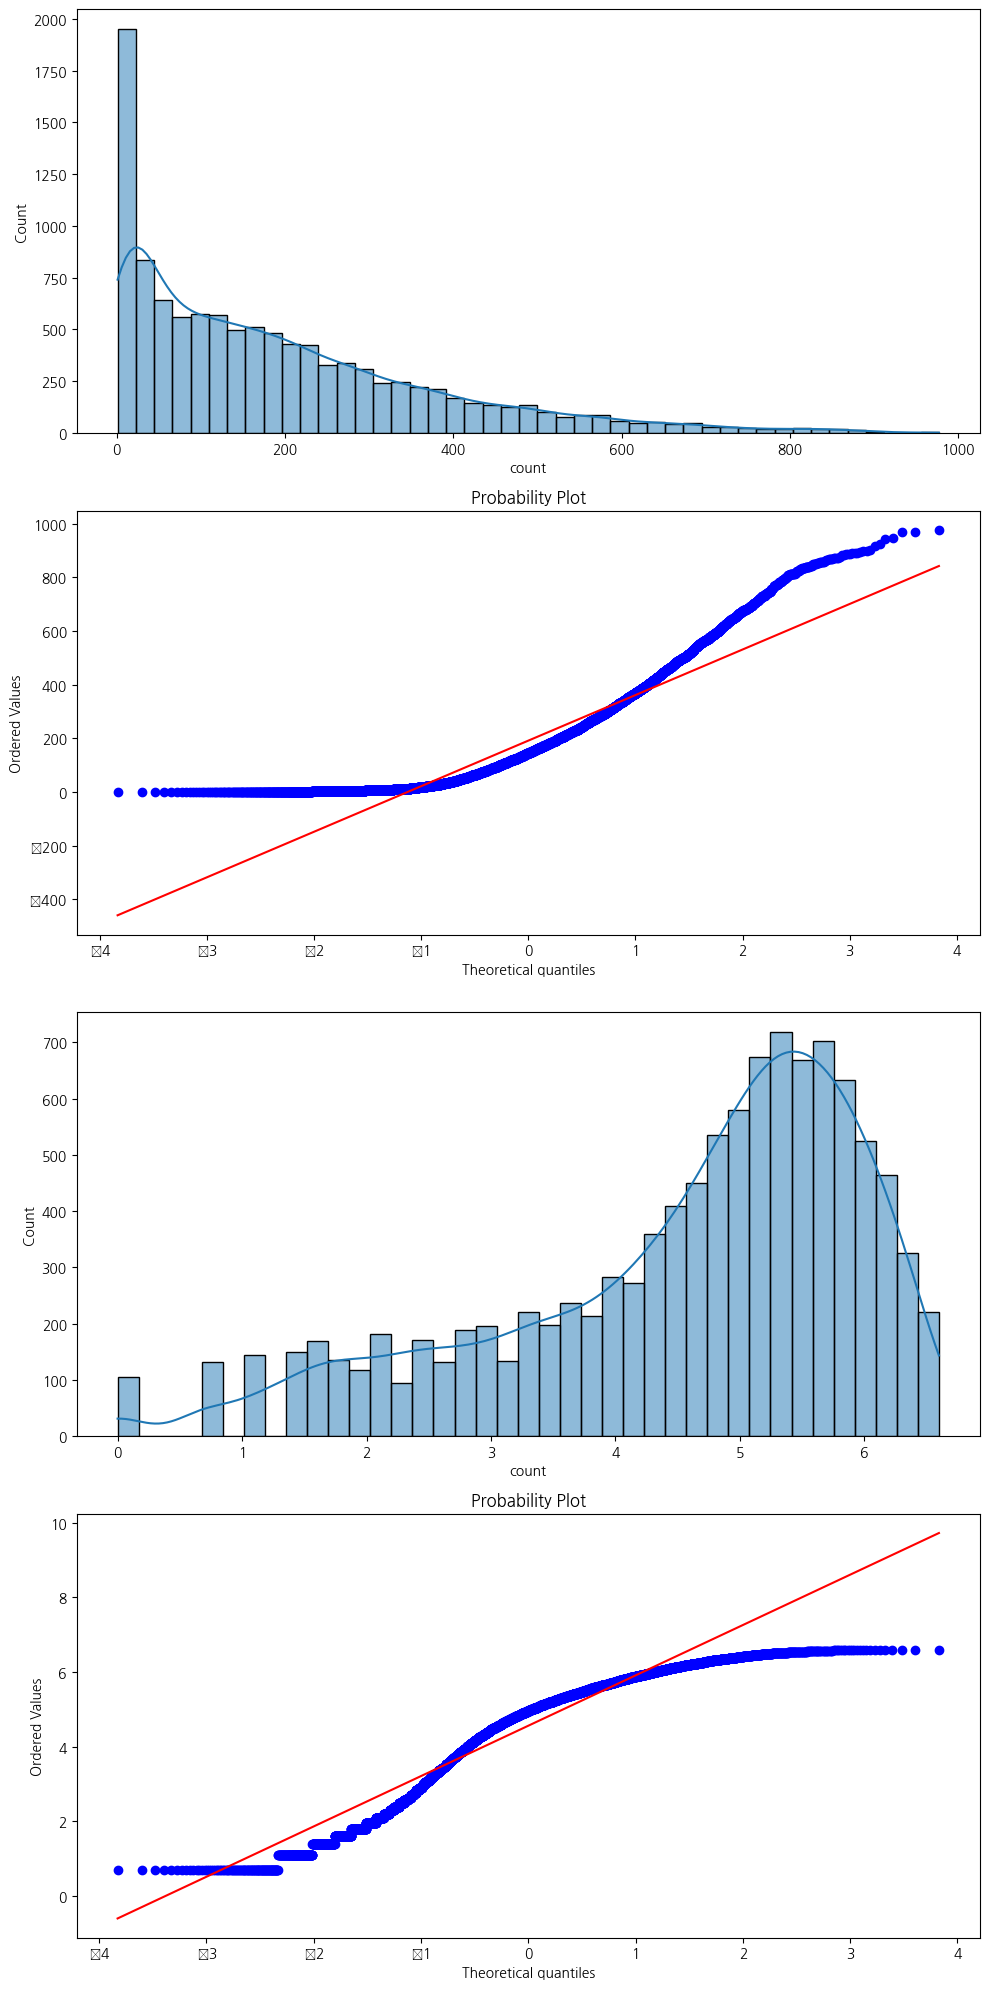

In [ ]:
from scipy import stats

figure, axes = plt.subplots(nrows=4, figsize=(10, 20))

# 히스토그램 커널 밀도 추정으로 특정 값에 치우쳐 있는지 확인
sns.histplot(train["count"], kde=True, ax=axes[0])

# 카운트에 대한 Q-Q플롯, 데이터 분포가 정규 분포와 얼마나 유사한지 확인 - 빨간색 선에 가깝게 위치할 수록 > 정규 분포
stats.probplot(train["count"], dist='norm', fit=True, plot=axes[1])

# 로그 변환으로 정규분포에 더 가깝게 되는지 확인
sns.histplot(np.log(cleantrain["count"]), kde=True, ax=axes[2])

# log(1+x)) 변환을 적용한 후의 Q-Q 플롯, 작은 값이 존재 할 경우 보다 더 정규 분포
stats.probplot(np.log1p(cleantrain["count"]), dist='norm', fit=True, plot=axes[3])

plt.tight_layout()
plt.show()

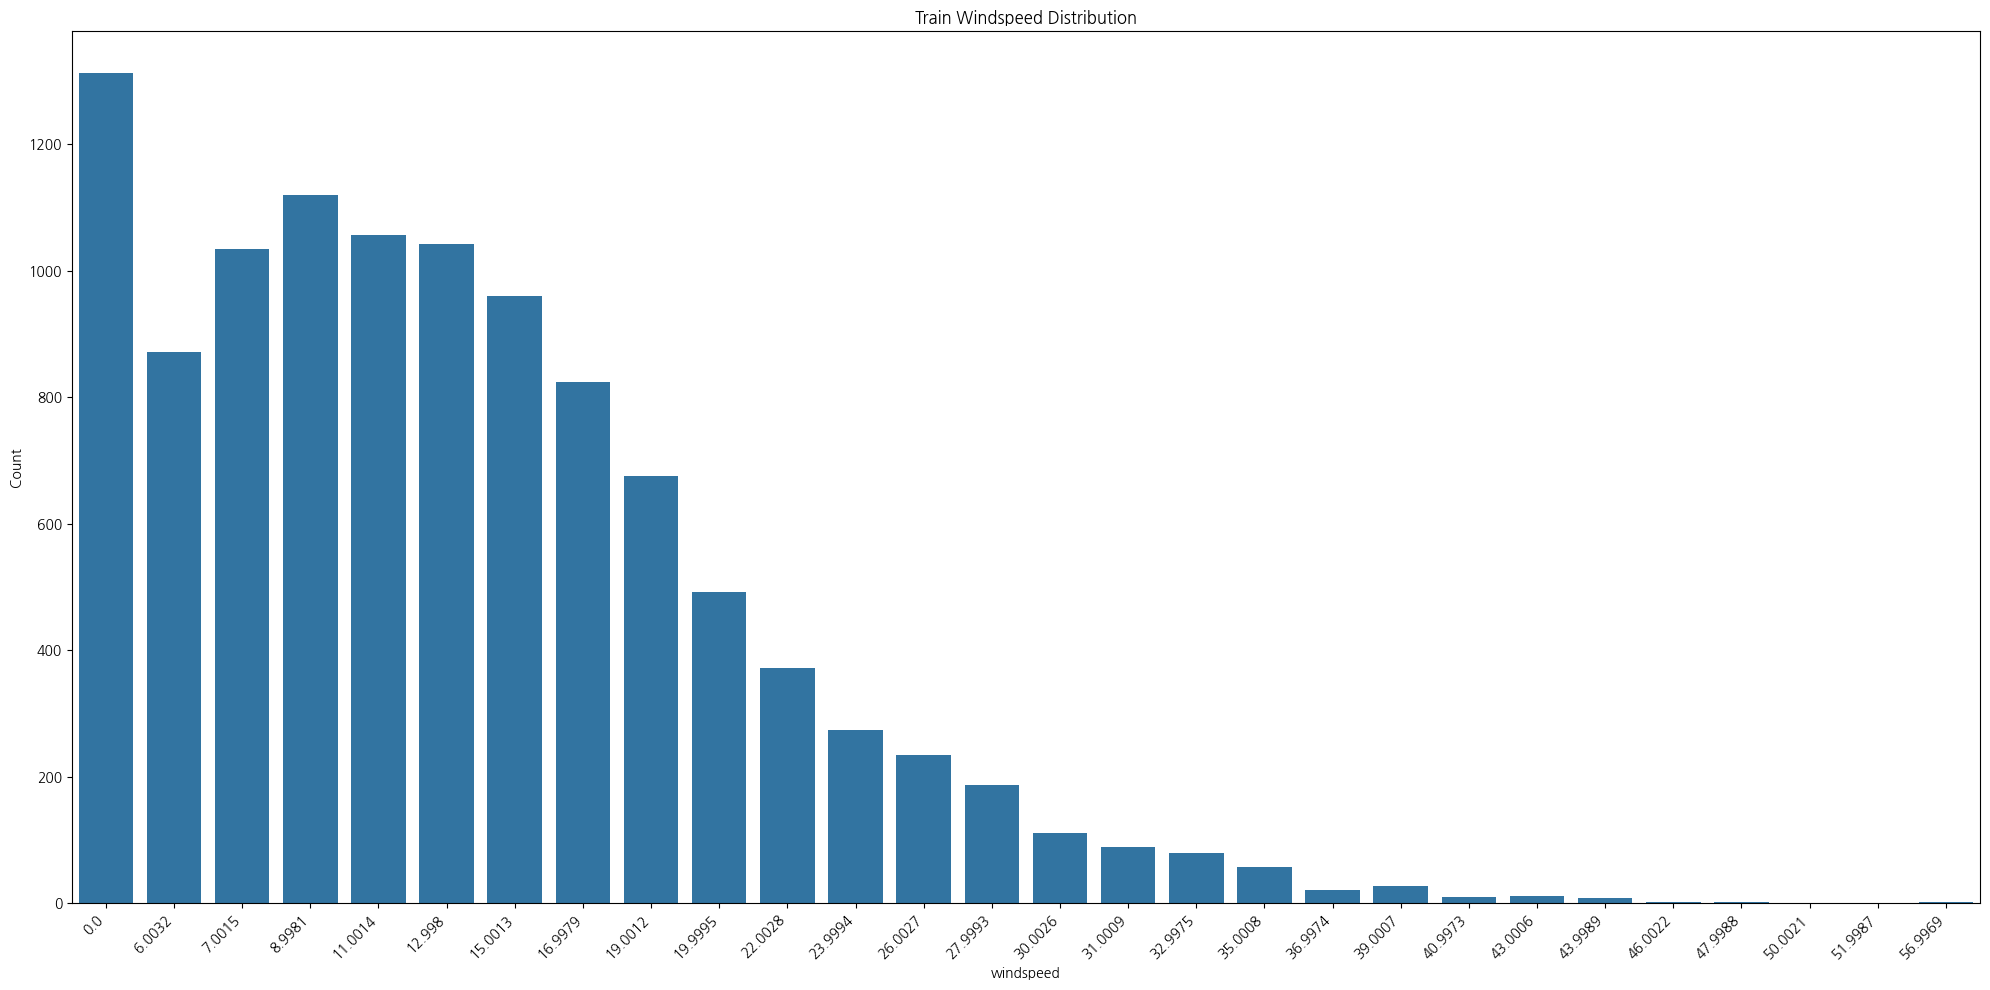

In [ ]:
# 풍속별 카운트 그래프

plt.figure(figsize=(20, 10))
sns.countplot(data=train, x="windspeed")
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.title("Train Windspeed Distribution")
plt.tight_layout()
plt.show()


In [ ]:
# 연속형 수치와 범주형 수치 속성 부여

categorical_var = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

for var in categorical_var:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [ ]:
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed",
                 "year", "hour", "dayofweek", "holiday", "workingday"]

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [ ]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,0.0,2011,0,5,0,0
1,1,1,9.02,13.635,80,0.0,2011,1,5,0,0
2,1,1,9.02,13.635,80,0.0,2011,2,5,0,0
3,1,1,9.84,14.395,75,0.0,2011,3,5,0,0
4,1,1,9.84,14.395,75,0.0,2011,4,5,0,0


In [ ]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [ ]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


,count
0,16
1,40
2,32
3,13
4,1


RMSLE
오차를 제곱해서 평균 낸 값으로 작을 수록 정밀도가 높음.
0에 가까운 값이 나올 수록 정밀도가 좋음.

In [ ]:
from sklearn.metrics import make_scorer

# RMSLE 계산 함수
def rmsle(y_true, y_pred):
    # 넘파이 배열로 변환
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # np.log1p = log(1+x)
    log_y_true = np.log1p(y_true)
    log_y_pred = np.log1p(y_pred)

    # 로그 값들의 차이를 제곱
    squared_log_diff = np.square(log_y_pred - log_y_true)

    # 차이 평균과 제곱근
    mean_squared_log_error = squared_log_diff.mean()
    rmsle_value = np.sqrt(mean_squared_log_error)

    return rmsle_value

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle, response_method='predict')

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              random_state=0)
model

RandomForestRegressor(n_jobs=-1, random_state=0)

In [ ]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
print("Score= {0:.5f}".format(score))

CPU times: user 53.2 s, sys: 281 ms, total: 53.4 s
Wall time: 29.9 s
Score= 0.33087


In [ ]:
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=0)

In [ ]:
predictions = model.predict(X_test)

predictions

array([ 11.48      ,   4.65      ,   4.18333333, ..., 110.35      ,
       103.89666667,  46.72      ])

/tmp/ipython-input-3458551531.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train,ax=ax1,bins=50)
/tmp/ipython-input-3458551531.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predictions,ax=ax2,bins=50)


[Text(0.5, 1.0, 'test')]

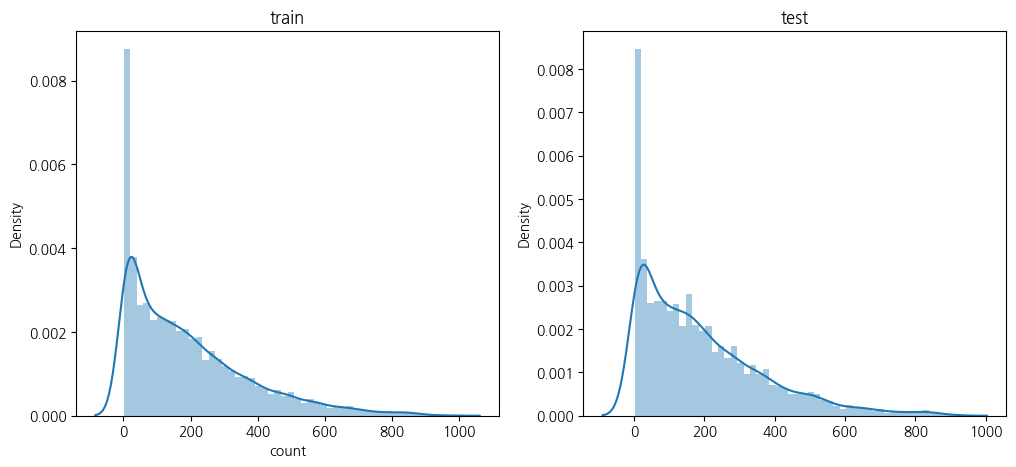

In [ ]:
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")

In [ ]:
def train_and_evaluate(model, X_train, y_train):
    y_log = np.log1p(y_train)
    model.fit(X_train, y_log)
    preds_log = model.predict(X_train)
    rmsle_score = rmsle(np.expm1(y_log), np.expm1(preds_log))
    return model, rmsle_score

In [ ]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=3,
    n_jobs=-1,
    random_state=42
)

gbm = GradientBoostingRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.7,
    random_state=42
)


In [ ]:
rf_model, rf_score = train_and_evaluate(rf, X_train, y_train)
gbm_model, gbm_score = train_and_evaluate(gbm, X_train, y_train)

print(f"RMSLE (Random Forest): {rf_score:.5f}")
print(f"RMSLE (Gradient Boosting): {gbm_score:.5f}")

RMSLE (Random Forest): 0.12355
RMSLE (Gradient Boosting): 0.22786


In [ ]:
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# 교차검증 + RMSLE 계산 함수
def train_and_evaluate(model, X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # 교차검증 점수 계산 (음수값이라 부호 변경)
    scores = -cross_val_score(
        model, X, y, scoring=rmsle_scorer, cv=kf, n_jobs=-1
    )

    # 평균 점수 사용
    mean_score = scores.mean()

    # 최종 학습 (실제 모델을 반환)
    model.fit(X, y)

    return model, mean_score

In [1]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=3,
    n_jobs=-1,
    random_state=42
)

gbm = GradientBoostingRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.7,
    random_state=42
)

rf_model, rf_score = train_and_evaluate(rf, X_train, y_train)
gbm_model, gbm_score = train_and_evaluate(gbm, X_train, y_train)

print(f"RMSLE (Random Forest): {rf_score:.5f}")
print(f"RMSLE (Gradient Boosting): {gbm_score:.5f}")

NameError: name 'train_and_evaluate' is not defined